In [1]:
import urllib.request
import zipfile
import os
from pathlib import Path

url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
zip_path = "sms_spam_collection.zip"
extracted_path = "sms_spam_collection"
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"

def download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path:Path):
    if data_file_path.exists():
        print(f'{data_file_path} already exists. Skipping download and extraction.')
        return
    with urllib.request.urlopen(url) as response:
        with open(zip_path, 'wb') as out_file:
            out_file.write(response.read())

    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extracted_path)

    original_file_path = Path(extracted_path) / "SMSSpamCollection"
    os.rename(original_file_path, data_file_path)
    print(f"File downloaded and saved as {data_file_path}")

download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)

sms_spam_collection\SMSSpamCollection.tsv already exists. Skipping download and extraction.


In [2]:
data_file_path

WindowsPath('sms_spam_collection/SMSSpamCollection.tsv')

In [3]:
import pandas as pd
df = pd.read_csv(data_file_path, sep='\t', header=None, names=["Label", "Text"])
df

,Label,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [4]:
sum(df['Label'] == 'ham'),sum(df['Label'] == 'spam')

(4825, 747)

In [5]:
df['Label'].value_counts()

Label
ham     4825
spam     747
Name: count, dtype: int64

In [6]:
df[df['Label']=='spam'].shape

(747, 2)

In [7]:
def create_balanced_dataset(df:pd.DataFrame):
    spam_nums = df[df['Label']=='spam'].shape[0]
    ham_subset = df[df['Label']=='ham'].sample(spam_nums, random_state=123)
    balanced_df = pd.concat([ham_subset, df[df['Label']=='spam']])
    return balanced_df

balanced_df = create_balanced_dataset(df)
balanced_df["Label"] = balanced_df["Label"].map({"ham":0,"spam":1}) # 将标签映射成0和1
balanced_df['Label'].value_counts()

Label
0    747
1    747
Name: count, dtype: int64

In [8]:
# 前面经过了抽取，此处的索引还是最开始加载的数据的索引，而不是0,1,2,3...
balanced_df['Label']

4307    0
4138    0
4831    0
4461    0
5440    0
       ..
5537    1
5540    1
5547    1
5566    1
5567    1
Name: Label, Length: 1494, dtype: int64

In [9]:
def random_split(df:pd.DataFrame, train_frac, validation_frac):
    df = df.sample(frac=1, random_state=123).reset_index(drop=True)
    train_end = int(len(df) * train_frac)
    validation_end =  train_end + int(len(df) * validation_frac)

    train_df = df[:train_end]
    validation_df = df[train_end:validation_end]
    test_df = df[validation_end:]

    return train_df, validation_df, test_df

train_df, validation_df, test_df = random_split(balanced_df, 0.7, 0.1)
train_df.to_csv("train.csv", index=None)
validation_df.to_csv("validation.csv", index=None)
test_df.to_csv("test.csv", index=None)

In [10]:
import torch
from torch.utils.data import Dataset
import tiktoken

tokenizer = tiktoken.get_encoding('gpt2')

class SpamDataset(Dataset):
    def __init__(self, csv_file, tokenizer, max_length=None, pad_token_id=50256):
        self.data = pd.read_csv(csv_file)
        self.encoded_texts = [tokenizer.encode(text) for text in self.data['Text']]
        if max_length is None:
            self.max_length = self._longest_encoded_length()
        else:
            self.max_length = max_length
            self.encoded_texts = [encoded_text[:max_length] for encoded_text in self.encoded_texts]
        # pad
        self.encoded_texts = [encoded_text + [pad_token_id] * (self.max_length - len(encoded_text)) for encoded_text in self.encoded_texts]

    def __getitem__(self, index):
        label = self.data.iloc[index]['Label']
        encoded = self.encoded_texts[index]
        return (torch.tensor(encoded, dtype=torch.long), torch.tensor(label, dtype=torch.long))
    
    def __len__(self):
        return len(self.encoded_texts)
    
    def _longest_encoded_length(self):
        max_length = 0
        for encoded_text in self.encoded_texts:
            if max_length < len(encoded_text):
                max_length = len(encoded_text)
        return max_length

In [11]:
train_dataset = SpamDataset(csv_file="train.csv", max_length=None, tokenizer=tokenizer)
print(train_dataset.max_length)

120


In [12]:
val_dataset = SpamDataset(csv_file="validation.csv", max_length=train_dataset.max_length, tokenizer=tokenizer)
test_dataset = SpamDataset(csv_file="test.csv", max_length=train_dataset.max_length, tokenizer=tokenizer)

In [13]:
from torch.utils.data import DataLoader

num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, drop_last=False)

In [14]:
train_dataset[0]

(tensor([   35,  2507,   703,   466,   345,   588,   262,  6940,  2344,    13,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256]),
 tensor(0))

In [15]:
for input_batch, target_batch in train_loader:
    pass
print("Input batch dimensions:", input_batch.shape)
print("Label batch dimensions:", target_batch.shape)

Input batch dimensions: torch.Size([8, 120])
Label batch dimensions: torch.Size([8])


In [16]:
print(f'Training batch: {len(train_loader)}')
print(f'Validation batch: {len(val_loader)}')
print(f'Test batch: {len(test_loader)}')

Training batch: 130
Validation batch: 19
Test batch: 38


In [17]:
CHOOSE_MODEL = "gpt2-small (124M)"
INPUT_PROMPT = "Every effort moves"
BASE_CONFIG = {
    "vocab_size": 50257, # Vocabulary size
    "context_length": 1024, # Context length
    "drop_rate": 0.0, # Dropout rate
    "qkv_bias": True # Query-key-value bias
}
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}
BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

assert train_dataset.max_length <= BASE_CONFIG["context_length"], (
    f"Dataset length {train_dataset.max_length} exceeds model's context "
    f"length {BASE_CONFIG['context_length']}. Reinitialize data sets with "
    f"`max_length={BASE_CONFIG['context_length']}`"
)

In [18]:
torch.arange(10)

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [19]:
import torch.nn as nn
pos_embed_layer = nn.Embedding(100, 256)
pos_embed_layer(torch.arange(10)).unsqueeze(0).transpose(-2,-1).shape
# torch.tensor([1]).unsqueeze

torch.Size([1, 256, 10])

In [20]:
torch.rand(5,5).masked_fill_(torch.triu(torch.ones(5,5),diagonal=1).bool(), -torch.inf)

tensor([[0.4146,   -inf,   -inf,   -inf,   -inf],
        [0.2121, 0.4498,   -inf,   -inf,   -inf],
        [0.0108, 0.7414, 0.0475,   -inf,   -inf],
        [0.0396, 0.2796, 0.4882, 0.8477,   -inf],
        [0.9495, 0.4145, 0.6140, 0.4895, 0.0454]])

In [21]:
torch.triu(torch.ones(5,5),diagonal=1).bool()[:4,:4]

tensor([[False,  True,  True,  True],
        [False, False,  True,  True],
        [False, False, False,  True],
        [False, False, False, False]])

In [22]:
## 尝试重新手写GPT模型

import torch
import torch.nn as nn

class MultiHeadAttention(nn.Module):
    def __init__(self, emb_dim, n_heads, qkv_bias, drop_rate, context_length):
        super().__init__()
        assert emb_dim % n_heads == 0, 'error'
        self.emb_dim = emb_dim
        self.n_heads = n_heads
        self.head_dim = emb_dim // n_heads
        self.W_q = nn.Linear(emb_dim, emb_dim, bias=qkv_bias)
        self.W_k = nn.Linear(emb_dim, emb_dim, bias=qkv_bias)
        self.W_v = nn.Linear(emb_dim, emb_dim, bias=qkv_bias)
        self.W_o = nn.Linear(emb_dim, emb_dim, bias=False)
        self.droput = nn.Dropout(drop_rate)
        # 写错了，不用赋值
        #self.mask = self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1).bool())
        self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1).bool())

    def forward(self, x:torch.Tensor): # shape (B,L,D)
        batch, seq_len, dim = x.shape
        # 先投影
        queries = self.W_q(x)
        keys = self.W_k(x)
        values = self.W_v(x)
        # 拆头
        queries = queries.view(batch, seq_len, self.n_heads, self.head_dim)
        keys = keys.view(batch, seq_len, self.n_heads, self.head_dim)
        values = values.view(batch, seq_len, self.n_heads, self.head_dim)
        # 交换位置
        queries = queries.transpose(-2, -3) # shape (B,H,L,H_D)
        keys = keys.transpose(-2, -3)
        values = values.transpose(-2, -3)
        # 计算
        scores = queries @ keys.transpose(-1,-2) / (keys.shape[-1] ** 0.5)
        scores.masked_fill_(self.mask[:seq_len, :seq_len], -torch.inf) # shape (B,H,L,L)
        # 这里也写错了，droput的位置错了，应该是对归一化后得到的注意力权重应用dropout，那下面这种写法可以么？
        #scores = self.droput(scores)
        #attn_weights = torch.softmax(scores) @ values # shape (B,H,L,H_D)
        # 改成：
        # dropout要在softmax之后做，dropout的目的让模型不要过度的依赖某些特定的位置，而是更多的关注上下文，
        # 所以dropout的目的是随机的让某些位置的注意力为0，这样在与Value矩阵相乘计算context_vec的时候会忽略掉那些被dropout掉的位置的信息
        # 如果将dropout放在softmax之前，是达不到这个效果的，因为经过dropout后注意力分数变成0的位置，在经过softmax后不再是0.
        attn_weights = torch.softmax(scores, dim=-1)
        attn_weights = self.droput(attn_weights)
        context_vec = attn_weights @ values
        context_vec = context_vec.transpose(-2,-3)
        context_vec = context_vec.contiguous().view(batch, seq_len, dim)
        # 输出
        out = self.W_o(context_vec)
        return out

class FeedLayer(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.lin1 = nn.Linear(emb_dim, emb_dim * 4)
        self.lin2 = nn.Linear(emb_dim * 4, emb_dim)
        self.act = nn.GELU()

    def forward(self, x): # (B,L,D)
        x = self.lin1(x)
        x = self.act(x)
        return self.lin2(x)

class TransformerBlk(nn.Module):
    def __init__(self, cfg:dict):
        super().__init__()
        self.norm1 = nn.LayerNorm(cfg['emb_dim'])
        self.norm2 = nn.LayerNorm(cfg['emb_dim'])
        self.attn = MultiHeadAttention(cfg['emb_dim'], cfg['n_heads'], cfg['qkv_bias'], cfg['drop_rate'])
        self.feed = FeedLayer(cfg['emb_dim'])
        self.dropout = nn.Dropout(cfg['drop_rate'])

    def forward(self, x):
        # 注意力层
        residual = x
        x = self.norm1(x)
        x = self.attn(x)
        # 原来写错了: 不是加了残差才dropout的，而是在注意力模块的输出加dropout
        #x = x + residual
        #x = self.dropout(x) #?
        x = self.dropout(x)
        x = x + residual

        # 前馈层
        residual = x
        x = self.norm2(x)
        x = self.feed(x)
        x = self.dropout(x) # 漏了
        x = x + residual
        return x

class GPTModel(nn.Module):
    def __init__(self, cfg:dict):
        super().__init__()
        self.embed_layer = nn.Embedding(cfg['vocab_size'], cfg['emb_dim'])
        self.pos_embed_layer = nn.Embedding(cfg['context_length'], cfg['emb_dim'])
        self.embed_drop = nn.Dropout(cfg['drop_rate'])
        self.trf_blks = nn.Sequential(*[TransformerBlk(cfg) for _ in range(cfg['n_layers'])])
        self.final_norm = nn.LayerNorm(cfg['emb_dim']) # 漏了
        self.out_head = nn.Linear(cfg['emb_dim'], cfg['vocab_size'])

    def forward(self, inputs): # inputs shape:(B,L)
        # embeding
        length = inputs.shape[1]
        embed = self.embed_layer(inputs)
        pos_embed = self.pos_embed_layer(torch.arange(length)).unsqueeze(0)
        x = embed + pos_embed # shape: (B,L,D)
        x = self.embed_drop(x) # 在得到嵌入后应用dropout，思路是：让模型在理解的时候，不依赖特定位置的输入
        # attn
        x = self.trf_blks(x) # shape:(B,L,D)
        x = self.final_norm(x)
        # out
        x = self.out_head(x)
        return x # shape(B,L,V)


In [23]:
import torch
import torch.nn as nn

class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))
        self.eps = 1e-5

    def forward(self, x:torch.Tensor):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        x_norm = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * x_norm + self.shift
    
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, num_heads, dropout, qkv_bias):
        super().__init__()
        assert d_out % num_heads == 0, "d_out must be divisible by num_heads"
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads
        self.W_q = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_k = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_v = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_o = nn.Linear(d_out, d_out)
        self.dropout = nn.Dropout(dropout)
        self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1).bool())

    def forward(self, x:torch.Tensor):
        batch, seq_len, dim = x.shape
        queries = self.W_q(x).view(batch, seq_len, self.num_heads, self.head_dim)
        keys = self.W_k(x).view(batch, seq_len, self.num_heads, self.head_dim)
        values = self.W_v(x).view(batch, seq_len, self.num_heads, self.head_dim)

        queries = queries.transpose(1, 2)  # (B, num_heads, L, head_dim)
        keys = keys.transpose(1, 2)        # (B, num_heads, L, head_dim)
        values = values.transpose(1, 2)    # (B, num_heads, L, head_dim)

        attn_scores = queries @ keys.transpose(-2, -1) / keys.shape[-1] ** 0.5 # （B, num_heads, L, L）
        attn_scores.masked_fill_(self.mask[:seq_len, :seq_len], -torch.inf)
        attn_weights = torch.softmax(attn_scores, dim=-1)
        attn_weights = self.dropout(attn_weights)
        context_vec = attn_weights @ values  # (B, num_heads, L, head_dim)
        context_vec = context_vec.transpose(1, 2).contiguous().view(batch, seq_len, dim)  # (B, L, D)
        return self.W_o(context_vec)
    
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(torch.sqrt(torch.tensor(2 / torch.pi)) * (x + 0.044715 * torch.pow(x, 3))))

class FeedForward(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.fc1 = nn.Linear(emb_dim, 4 * emb_dim)
        self.fc2 = nn.Linear(4 * emb_dim, emb_dim)
        # self.act = nn.GELU()
        self.act = GELU()

    def forward(self, x:torch.Tensor):
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        return x
    
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.norm1 = LayerNorm(cfg['emb_dim'])
        self.norm2 = LayerNorm(cfg['emb_dim'])
        self.attn = MultiHeadAttention(cfg['emb_dim'], cfg['emb_dim'], cfg['context_length'], cfg['n_heads'], cfg['drop_rate'], cfg['qkv_bias'])
        self.ffn = FeedForward(cfg['emb_dim'])
        self.dropout = nn.Dropout(cfg['drop_rate'])
    
    def forward(self, x:torch.Tensor):
        # 多头
        shortcut = x
        x = self.norm1(x)
        x = self.attn(x)
        x = self.dropout(x)
        x = x + shortcut
        # 前馈层
        shortcut = x
        x = self.norm2(x)
        x = self.ffn(x)
        x = self.dropout(x)
        return x + shortcut

class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.token_emb = nn.Embedding(cfg['vocab_size'], cfg['emb_dim'])
        self.pos_emb = nn.Embedding(cfg['context_length'], cfg['emb_dim'])
        self.drop_emp = nn.Dropout(cfg['drop_rate'])
        self.blks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg['n_layers'])]
        )
        self.final_norm = LayerNorm(cfg['emb_dim'])
        self.out_head = nn.Linear(cfg['emb_dim'], cfg['vocab_size'])

    def forward(self, in_idx:torch.Tensor):
        batch, seq_len = in_idx.shape
        token_embeded = self.token_emb(in_idx) # (B,L,D)
        pos_embeded = self.pos_emb(torch.arange(seq_len, device=in_idx.device)) # (L,D)
        x = token_embeded + pos_embeded  # (B,L,D)
        x = self.drop_emp(x) # (B,L,D)
        x = self.blks(x) # (B,L,D)
        x = self.final_norm(x) # (B,L,D)
        logits = self.out_head(x) # (B,L,V)
        return logits

In [24]:
# Listing 5.5 Loading OpenAI weights into our GPT model code
import numpy as np

def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))

def load_weights_into_gpt(gpt, params):
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])               #A
    gpt.token_emb.weight = assign(gpt.token_emb.weight, params['wte'])
    for b in range(len(params["blocks"])):                                       #B
        q_w, k_w, v_w = np.split(                                                #C
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.blks[b].attn.W_q.weight = assign(
            gpt.blks[b].attn.W_q.weight, q_w.T)
        gpt.blks[b].attn.W_k.weight = assign(
            gpt.blks[b].attn.W_k.weight, k_w.T)
        gpt.blks[b].attn.W_v.weight = assign(
            gpt.blks[b].attn.W_v.weight, v_w.T)

        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.blks[b].attn.W_q.bias = assign(
            gpt.blks[b].attn.W_q.bias, q_b)
        gpt.blks[b].attn.W_k.bias = assign(
            gpt.blks[b].attn.W_k.bias, k_b)
        gpt.blks[b].attn.W_v.bias = assign(
            gpt.blks[b].attn.W_v.bias, v_b)

        gpt.blks[b].attn.W_o.weight = assign(
            gpt.blks[b].attn.W_o.weight,
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.blks[b].attn.W_o.bias = assign(
            gpt.blks[b].attn.W_o.bias,
            params["blocks"][b]["attn"]["c_proj"]["b"])

        gpt.blks[b].ffn.fc1.weight = assign(
            gpt.blks[b].ffn.fc1.weight,
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.blks[b].ffn.fc1.bias = assign(
            gpt.blks[b].ffn.fc1.bias,
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.blks[b].ffn.fc2.weight = assign(
            gpt.blks[b].ffn.fc2.weight,
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.blks[b].ffn.fc2.bias = assign(
            gpt.blks[b].ffn.fc2.bias,
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        gpt.blks[b].norm1.scale = assign(
            gpt.blks[b].norm1.scale,
            params["blocks"][b]["ln_1"]["g"])
        gpt.blks[b].norm1.shift = assign(
            gpt.blks[b].norm1.shift,
            params["blocks"][b]["ln_1"]["b"])
        gpt.blks[b].norm2.scale = assign(
            gpt.blks[b].norm2.scale,
            params["blocks"][b]["ln_2"]["g"])
        gpt.blks[b].norm2.shift = assign(
            gpt.blks[b].norm2.shift,
            params["blocks"][b]["ln_2"]["b"])

    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])


#A 将模型的位置嵌入和token 嵌入的权重设置为 params 中指定的值
#B 遍历模型中的每个 Transformer 模块
#C 使用 np.split 函数将注意力和偏置权重分为三等份，分别用于查询、键和值组件
#D OpenAI 的原始 GPT-2 模型在输出层中复用了 token 嵌入的权重，以减少参数总量，这一概念称为权重共享


In [25]:
from gpt_download import download_and_load_gpt2

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
print(model_size)
settings, params = download_and_load_gpt2(model_size=model_size, models_dir="gpt2")

124M
File already exists and is up-to-date: gpt2\124M\checkpoint
File already exists and is up-to-date: gpt2\124M\encoder.json
File already exists and is up-to-date: gpt2\124M\hparams.json
File already exists and is up-to-date: gpt2\124M\model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2\124M\model.ckpt.index
File already exists and is up-to-date: gpt2\124M\model.ckpt.meta
File already exists and is up-to-date: gpt2\124M\vocab.bpe


In [26]:
model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval()

GPTModel(
  (token_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emp): Dropout(p=0.0, inplace=False)
  (blks): Sequential(
    (0): TransformerBlock(
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (attn): MultiHeadAttention(
        (W_q): Linear(in_features=768, out_features=768, bias=True)
        (W_k): Linear(in_features=768, out_features=768, bias=True)
        (W_v): Linear(in_features=768, out_features=768, bias=True)
        (W_o): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ffn): FeedForward(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (act): GELU()
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (attn): MultiHeadAttention(
        (W_q): Linear(in_features=768, out_feat

In [27]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:] # 取从当前序列的最后context_size个token作为条件输入
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]  # 取最后一个时间步的logits
        # probas = torch.softmax(logits, dim=-1)
        # idx_next = torch.argmax(probas, dim=-1, keepdim=True)
        idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # logits和probas的大小关系是对应的，所以可以直接对logits应用argmax得到词元id
        idx = torch.cat((idx, idx_next), dim=1)
    return idx

import tiktoken
def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # 添加batch维度
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0)
    return tokenizer.decode(flat.tolist())

In [28]:
text_1 = "Every effort moves you"

token_ids = generate_text_simple(model=model, 
                                 idx=text_to_token_ids(text_1, tokenizer), 
                                 max_new_tokens=15, 
                                 context_size=BASE_CONFIG['context_length'])
print(token_ids_to_text(token_ids, tokenizer))

Every effort moves you forward.

The first step is to understand the importance of your work


In [29]:
# 分类微调，替换输出层
torch.manual_seed(123)
num_classes = 2
model.out_head = torch.nn.Linear(in_features=BASE_CONFIG['emb_dim'], out_features=num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

GPTModel(
  (token_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emp): Dropout(p=0.0, inplace=False)
  (blks): Sequential(
    (0): TransformerBlock(
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (attn): MultiHeadAttention(
        (W_q): Linear(in_features=768, out_features=768, bias=True)
        (W_k): Linear(in_features=768, out_features=768, bias=True)
        (W_v): Linear(in_features=768, out_features=768, bias=True)
        (W_o): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ffn): FeedForward(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (act): GELU()
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (attn): MultiHeadAttention(
        (W_q): Linear(in_features=768, out_feat

In [30]:
# 计算分类正确率
def calc_accuracy_loader(data_loader:DataLoader, model:nn.Module, device:torch.device, num_batches=None):
    model.eval()
    correct_prediction, num_examples = 0, 0
    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for idx, (input_batch, target_batch) in enumerate(data_loader):
        if idx >= num_batches:
            break
        input_batch = input_batch.to(device)
        target_batch = target_batch.to(device)
        with torch.no_grad():
            logits = model(input_batch)[:,-1,:] # 取最后一个token
        predictions = torch.argmax(logits, dim=-1)
        num_examples += predictions.shape[0]
        correct_prediction += ((predictions == target_batch).sum().item())
    return correct_prediction / num_examples

In [31]:
torch.manual_seed(123)
train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=10)
val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=10)
test_accuracy = calc_accuracy_loader(test_loader, model, device, num_batches=10)
print(f"Train accuracy: {train_accuracy*100:.4f}%, Val accuracy: {val_accuracy*100:.4f}%, Test accuracy: {test_accuracy*100:.4f}%")

Train accuracy: 46.2500%, Val accuracy: 45.0000%, Test accuracy: 48.7500%


In [32]:
# 定义一个Lora层
import math

class LoRALayer(nn.Module):
    def __init__(self, in_dim, out_dim, rank, alpha):
        super().__init__()
        self.A = nn.Parameter(torch.empty(in_dim, rank))
        nn.init.kaiming_uniform_(self.A, a=math.sqrt(5))
        self.B = nn.Parameter(torch.zeros(rank, out_dim)) # 矩阵B初始化为0，这样初始时Lora层的输出为0
        self.alpha = alpha
    
    def forward(self, x):
        x = self.alpha * (x @ self.A @ self.B)
        return x

In [33]:
# 用于替换原始模型的线性层

class LinearWithLoRA(nn.Module):
    def __init__(self, linear:nn.Linear, rank, alpha):
        super().__init__()
        self.linear = linear # 原来的线性层
        self.lora = LoRALayer(linear.in_features, linear.out_features, rank, alpha)

    def forward(self, x):
        return self.linear(x) + self.lora(x)

In [34]:
# 替换原模型的线性层的工具方法

def replace_linear_with_lora(model:nn.Module, rank, alpha):
    for name, module in model.named_children():
        if isinstance(module, torch.nn.Linear):
            setattr(model, name, LinearWithLoRA(module, rank, alpha))
        else: # 递归到子模块去
            replace_linear_with_lora(module, rank, alpha)

In [35]:
for name, module in model.named_children():
    print(name)

token_emb
pos_emb
drop_emp
blks
final_norm
out_head


In [36]:
# 先冻结原模型所有参数
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Total trainable parameters before: {total_params:,}')

for param in model.parameters():
    param.requires_grad = False

total_params = sum(p for p in model.parameters() if p.requires_grad)
print(f'Total trainable parameters after:{total_params:,}')

Total trainable parameters before: 124,441,346
Total trainable parameters after:0


In [37]:
# 接着替换掉原模型中的所有线性层
replace_linear_with_lora(model, rank=16, alpha=16)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Total trainable LoRA parameters:{total_params:,}')

Total trainable LoRA parameters:2,666,528


In [38]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(model)

GPTModel(
  (token_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emp): Dropout(p=0.0, inplace=False)
  (blks): Sequential(
    (0): TransformerBlock(
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (attn): MultiHeadAttention(
        (W_q): LinearWithLoRA(
          (linear): Linear(in_features=768, out_features=768, bias=True)
          (lora): LoRALayer()
        )
        (W_k): LinearWithLoRA(
          (linear): Linear(in_features=768, out_features=768, bias=True)
          (lora): LoRALayer()
        )
        (W_v): LinearWithLoRA(
          (linear): Linear(in_features=768, out_features=768, bias=True)
          (lora): LoRALayer()
        )
        (W_o): LinearWithLoRA(
          (linear): Linear(in_features=768, out_features=768, bias=True)
          (lora): LoRALayer()
        )
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ffn): FeedForward(
        (fc1): LinearWithLoRA(
          (linear): Linear(in_features=768, out_

In [39]:
torch.manual_seed(123)
train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=10)
val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=10)
test_accuracy = calc_accuracy_loader(test_loader, model, device, num_batches=10)

print(f'Training accuracy:{train_accuracy*100:.2f}%')
print(f'Validation accuracy:{val_accuracy*100:.2f}%')
print(f'Test accuracy:{test_accuracy*100:.2f}%')

Training accuracy:46.25%
Validation accuracy:45.00%
Test accuracy:48.75%


In [40]:
def calc_loss_batch(input_batch:torch.Tensor, target_batch:torch.Tensor, model:nn.Module, device):
    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device)
    logits = model(input_batch)[:,-1,:]
    loss = torch.nn.functional.cross_entropy(logits, target_batch)
    return loss

In [41]:
def calc_loss_loader(data_loader:DataLoader, model:nn.Module, device:torch.device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [42]:
def evaluate_model(model:torch.nn.Module, train_loader:DataLoader, val_loader:DataLoader, device:torch.device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

def train_classifier_simple(model:nn.Module, train_loader:DataLoader, val_loader:DataLoader, optimizer:torch.optim.Optimizer, device:torch.device, num_epochs, eval_freq, eval_iter):
    train_losses, val_losses, train_accs, val_accs = [],[],[],[]
    example_seen, global_step = 0, -1

    for epoch in range(num_epochs):
        model.train()
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()
            optimizer.step()
            example_seen += input_batch.shape[0]
            global_step += 1

            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                print(f'Ep {epoch+1} (Step {global_step:06d}):Train loss {train_loss:.3f} Val loss {val_loss:.3f}')

        # 每轮后算下准确率
        train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=eval_iter)
        val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=eval_iter)

        print(f"Training accuracy: {train_accuracy*100:.2f}% | ", end="")
        print(f"Validation accuracy: {val_accuracy*100:.2f}%")
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)
        
    return train_losses, val_losses, train_accs, val_accs, example_seen


In [43]:
import time
start_time = time.time()
torch.manual_seed(123)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)

num_epochs = 5
train_losses, val_losses, train_accs, val_accs, example_seen = train_classifier_simple(model, train_loader, val_loader, optimizer, device, num_epochs=num_epochs, eval_freq=50, eval_iter=5)
end_time = time.time()
exec_time_min = (end_time - start_time) / 60
print(f'Training compledt in {exec_time_min:.2f} min.')

Ep 1 (Step 000000):Train loss 3.820 Val loss 3.462
Ep 1 (Step 000050):Train loss 0.396 Val loss 0.364
Ep 1 (Step 000100):Train loss 0.111 Val loss 0.229
Training accuracy: 97.50% | Validation accuracy: 95.00%
Ep 2 (Step 000150):Train loss 0.135 Val loss 0.073
Ep 2 (Step 000200):Train loss 0.007 Val loss 0.054
Ep 2 (Step 000250):Train loss 0.021 Val loss 0.182
Training accuracy: 97.50% | Validation accuracy: 97.50%
Ep 3 (Step 000300):Train loss 0.101 Val loss 0.070
Ep 3 (Step 000350):Train loss 0.027 Val loss 0.122
Training accuracy: 100.00% | Validation accuracy: 92.50%
Ep 4 (Step 000400):Train loss 0.016 Val loss 0.014
Ep 4 (Step 000450):Train loss 0.010 Val loss 0.047
Ep 4 (Step 000500):Train loss 0.001 Val loss 0.070
Training accuracy: 100.00% | Validation accuracy: 95.00%
Ep 5 (Step 000550):Train loss 0.001 Val loss 0.189
Ep 5 (Step 000600):Train loss 0.022 Val loss 0.146
Training accuracy: 100.00% | Validation accuracy: 100.00%
Training compledt in 0.45 min.


In [44]:
import matplotlib.pyplot as plt
def plot_values(epochs_seen, examples_seen, train_values, val_values, label="loss"):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    ax1.plot(epochs_seen, train_values, label=f"Training {label}")    #A
    ax1.plot(epochs_seen, val_values, linestyle="-.", label=f"Validation {label}")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()

    ax2 = ax1.twiny()                                                 #B
    ax2.plot(examples_seen, train_values, alpha=0) # Invisible plot for aligning ticks
    ax2.set_xlabel("Examples seen")

    fig.tight_layout()                                                #C
    plt.savefig(f"{label}-plot.pdf")
    plt.show()

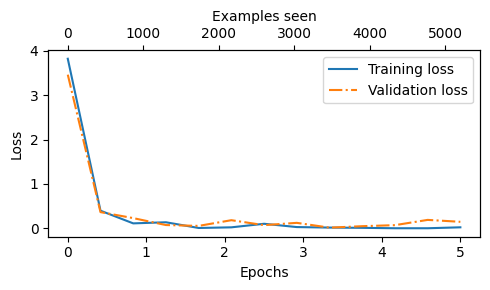

In [45]:


epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, example_seen, len(train_losses))

plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses, label="loss")


In [46]:
torch.manual_seed(123)
train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=10)
val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=10)
test_accuracy = calc_accuracy_loader(test_loader, model, device, num_batches=10)

print(f'Training accuracy:{train_accuracy*100:.2f}%')
print(f'Validation accuracy:{val_accuracy*100:.2f}%')
print(f'Test accuracy:{test_accuracy*100:.2f}%')

Training accuracy:100.00%
Validation accuracy:100.00%
Test accuracy:97.50%


尝试下通过LoRA仅微调注意力模块

结论：感觉其实差不多，就是相比上面使用LoRA微调全部的liner层要稍微差一点

In [47]:
model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval()

GPTModel(
  (token_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emp): Dropout(p=0.0, inplace=False)
  (blks): Sequential(
    (0): TransformerBlock(
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (attn): MultiHeadAttention(
        (W_q): Linear(in_features=768, out_features=768, bias=True)
        (W_k): Linear(in_features=768, out_features=768, bias=True)
        (W_v): Linear(in_features=768, out_features=768, bias=True)
        (W_o): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ffn): FeedForward(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (act): GELU()
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (attn): MultiHeadAttention(
        (W_q): Linear(in_features=768, out_feat

In [48]:
# 分类微调，替换输出层
torch.manual_seed(123)
num_classes = 2
model.out_head = torch.nn.Linear(in_features=BASE_CONFIG['emb_dim'], out_features=num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

GPTModel(
  (token_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emp): Dropout(p=0.0, inplace=False)
  (blks): Sequential(
    (0): TransformerBlock(
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (attn): MultiHeadAttention(
        (W_q): Linear(in_features=768, out_features=768, bias=True)
        (W_k): Linear(in_features=768, out_features=768, bias=True)
        (W_v): Linear(in_features=768, out_features=768, bias=True)
        (W_o): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ffn): FeedForward(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (act): GELU()
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (attn): MultiHeadAttention(
        (W_q): Linear(in_features=768, out_feat

In [49]:
# 先冻结原模型所有参数
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Total trainable parameters before: {total_params:,}')

for param in model.parameters():
    param.requires_grad = False

total_params = sum(p for p in model.parameters() if p.requires_grad)
print(f'Total trainable parameters after:{total_params:,}')

Total trainable parameters before: 124,441,346
Total trainable parameters after:0


In [52]:
def replace_qkv_linear_with_lora(model:nn.Module, rank, alpha):
    for name, module in model.named_children():
        if isinstance(module, MultiHeadAttention):
            # setattr(model, name, LinearWithLoRA(module, rank, alpha))
            for name, layer in module.named_children():
                if name in ('W_q', 'W_k', 'W_v', 'W_o'):
                    # print(name, layer)
                    setattr(module, name, LinearWithLoRA(layer, rank, alpha))
        else: # 递归到子模块去
            replace_qkv_linear_with_lora(module, rank, alpha)

In [ ]:
# 分类微调，替换输出层
torch.manual_seed(123)
num_classes = 2
model.out_head = torch.nn.Linear(in_features=BASE_CONFIG['emb_dim'], out_features=num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(model)

GPTModel(
  (token_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emp): Dropout(p=0.0, inplace=False)
  (blks): Sequential(
    (0): TransformerBlock(
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (attn): MultiHeadAttention(
        (W_q): Linear(in_features=768, out_features=768, bias=True)
        (W_k): Linear(in_features=768, out_features=768, bias=True)
        (W_v): Linear(in_features=768, out_features=768, bias=True)
        (W_o): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ffn): FeedForward(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (act): GELU()
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (attn): MultiHeadAttention(
        (W_q): Linear(in_features=768, out_feat

In [50]:
torch.manual_seed(123)
train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=10)
val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=10)
test_accuracy = calc_accuracy_loader(test_loader, model, device, num_batches=10)

print(f'Training accuracy:{train_accuracy*100:.2f}%')
print(f'Validation accuracy:{val_accuracy*100:.2f}%')
print(f'Test accuracy:{test_accuracy*100:.2f}%')

Training accuracy:46.25%
Validation accuracy:45.00%
Test accuracy:48.75%


In [53]:
# 接着替换掉原模型中的qkv模块
replace_qkv_linear_with_lora(model, rank=16, alpha=16)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Total trainable LoRA parameters:{total_params:,}')

Total trainable LoRA parameters:1,179,648


In [54]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(model)

GPTModel(
  (token_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emp): Dropout(p=0.0, inplace=False)
  (blks): Sequential(
    (0): TransformerBlock(
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (attn): MultiHeadAttention(
        (W_q): LinearWithLoRA(
          (linear): Linear(in_features=768, out_features=768, bias=True)
          (lora): LoRALayer()
        )
        (W_k): LinearWithLoRA(
          (linear): Linear(in_features=768, out_features=768, bias=True)
          (lora): LoRALayer()
        )
        (W_v): LinearWithLoRA(
          (linear): Linear(in_features=768, out_features=768, bias=True)
          (lora): LoRALayer()
        )
        (W_o): LinearWithLoRA(
          (linear): Linear(in_features=768, out_features=768, bias=True)
          (lora): LoRALayer()
        )
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ffn): FeedForward(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (f

In [55]:
torch.manual_seed(123)
train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=10)
val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=10)
test_accuracy = calc_accuracy_loader(test_loader, model, device, num_batches=10)

print(f'Training accuracy:{train_accuracy*100:.2f}%')
print(f'Validation accuracy:{val_accuracy*100:.2f}%')
print(f'Test accuracy:{test_accuracy*100:.2f}%')

Training accuracy:46.25%
Validation accuracy:45.00%
Test accuracy:48.75%


In [56]:
import time
start_time = time.time()
torch.manual_seed(123)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)

num_epochs = 5
train_losses, val_losses, train_accs, val_accs, example_seen = train_classifier_simple(model, train_loader, val_loader, optimizer, device, num_epochs=num_epochs, eval_freq=50, eval_iter=5)
end_time = time.time()
exec_time_min = (end_time - start_time) / 60
print(f'Training compledt in {exec_time_min:.2f} min.')

Ep 1 (Step 000000):Train loss 2.330 Val loss 2.069
Ep 1 (Step 000050):Train loss 0.432 Val loss 0.386
Ep 1 (Step 000100):Train loss 0.179 Val loss 0.393
Training accuracy: 92.50% | Validation accuracy: 95.00%
Ep 2 (Step 000150):Train loss 0.166 Val loss 0.074
Ep 2 (Step 000200):Train loss 0.046 Val loss 0.050
Ep 2 (Step 000250):Train loss 0.079 Val loss 0.050
Training accuracy: 97.50% | Validation accuracy: 97.50%
Ep 3 (Step 000300):Train loss 0.014 Val loss 0.170
Ep 3 (Step 000350):Train loss 0.011 Val loss 0.142
Training accuracy: 100.00% | Validation accuracy: 95.00%
Ep 4 (Step 000400):Train loss 0.006 Val loss 0.151
Ep 4 (Step 000450):Train loss 0.026 Val loss 0.207
Ep 4 (Step 000500):Train loss 0.022 Val loss 0.015
Training accuracy: 100.00% | Validation accuracy: 100.00%
Ep 5 (Step 000550):Train loss 0.067 Val loss 0.007
Ep 5 (Step 000600):Train loss 0.002 Val loss 0.062
Training accuracy: 100.00% | Validation accuracy: 97.50%
Training compledt in 0.39 min.


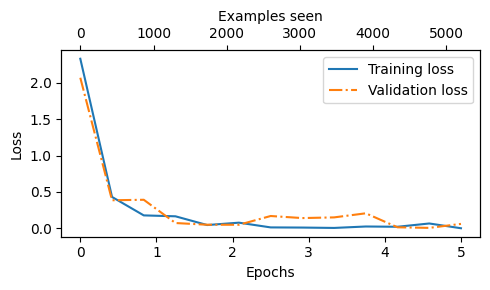

In [57]:


epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, example_seen, len(train_losses))

plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses, label="loss")


In [60]:
torch.manual_seed(123)
train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=10)
val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=10)
test_accuracy = calc_accuracy_loader(test_loader, model, device, num_batches=10)

print(f'Training accuracy:{train_accuracy*100:.2f}%')
print(f'Validation accuracy:{val_accuracy*100:.2f}%')
print(f'Test accuracy:{test_accuracy*100:.2f}%')

Training accuracy:98.75%
Validation accuracy:98.75%
Test accuracy:96.25%
